## Question: What facts may be inferred from the closed polylogarithmic form of $k_n(x)$?

Through much fiddling, I've managed to find the following closed-form representation of equations 17.x from my original paper:

$$
y(x) = \frac{x\ln(x)}{x-1} = \phi\bigg(\frac{x-1}{x}, 1, 1\bigg) = \frac{x}{x-1} Li_1\bigg(\frac{x-1}{x}\bigg) \\
k_n(x) = \frac{ \frac{x}{n} - \phi\bigg(\frac{x-1}{x}, 1, n\bigg) }{x-1} \\
p_n(x) = \frac{k_n(x)}{y(x)} = \frac{ \frac{x}{n} - \phi\bigg(\frac{x-1}{x}, 1, n\bigg) }{x\ln(x)}
$$

- Can these be simplified further?
- What the hell does it mean?
- Can the paper's original assertions be re-proved given this form?

In [1]:
# bloody dependencies
import matplotlib.pyplot as plt
from nltk.corpus import gutenberg
from mpmath import lerchphi, polylog
import numpy as np
import pandas as pd
from scipy.special import zeta, zetac
from scipy.optimize import fsolve

# custom classes
from legomena import Corpus, SPGC, LogModel

In [2]:
# standard project gutenberg corpus
spgc = SPGC.metadata(language='en')

# preview
spgc.head()

,title,author,authoryearofbirth,authoryearofdeath,language,downloads,subjects,type
id,,,,,,,,
1,The Declaration of Independence of the United ...,"Jefferson, Thomas",1743.0,1826.0,['en'],604.0,"{'United States -- History -- Revolution, 1775...",Text
2,The United States Bill of Rights: The Ten Orig...,United States,NaN,NaN,['en'],158.0,"{'Civil rights -- United States -- Sources', '...",Text
3,John F. Kennedy's Inaugural Address,"Kennedy, John F. (John Fitzgerald)",1917.0,1963.0,['en'],28.0,{'Presidents -- United States -- Inaugural add...,Text
4,Lincoln's Gettysburg Address: Given November 1...,"Lincoln, Abraham",1809.0,1865.0,['en'],55.0,{'Consecration of cemeteries -- Pennsylvania -...,Text
5,The United States Constitution,United States,NaN,NaN,['en'],226.0,"{'United States. Constitution', 'United States...",Text


### Choosing a Book

Select a book for use as our fitting corpus.

Optimum = LogParams(M_z=112513, N_z=12218)


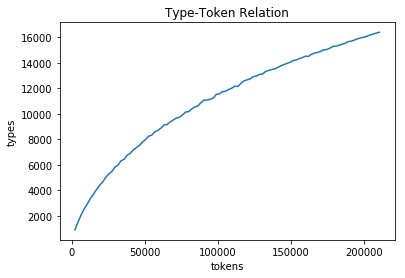

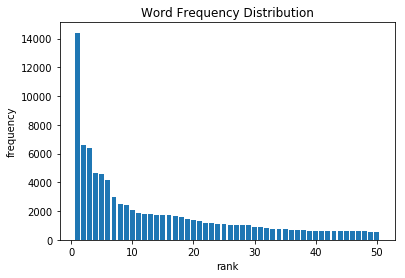

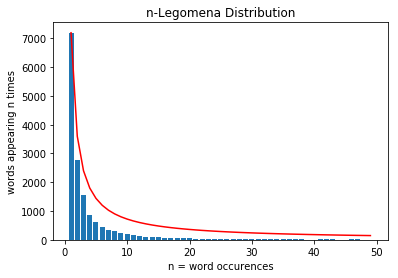

In [3]:
# spgc[spgc.title.str.contains("Bible", na = False)].head()

# moby dick
corpus = SPGC.get(2701)
TTR = corpus.TTR
model = LogModel().fit(TTR.m_tokens, TTR.n_types)
print("Optimum =", model.params)

# plot TTR curve
plt.plot(TTR.m_tokens, TTR.n_types)
plt.title("Type-Token Relation")
plt.xlabel("tokens")
plt.ylabel("types")
plt.show()

# plot WFD
xmax = 50
df = corpus.fdist.copy().head(xmax)
plt.bar(df.index, df["freq"])
plt.title("Word Frequency Distribution")
plt.xlabel("rank")
plt.ylabel("frequency")
plt.show()

# plot the k-vector
i = range(1,50)
plt.bar(i, corpus.k[i])
plt.plot(i, corpus.k[1]/i, color = 'r')
plt.title("n-Legomena Distribution")
plt.xlabel("n = word occurences")
plt.ylabel("words appearing n times")
plt.show()

,m_tokens,n_types,lego_0,lego_1,lego_2,lego_3,x,y
0,2102,894,15508,681,93,36,0.018682,0.073171
1,4205,1510,14892,1124,168,43,0.037373,0.123588
2,6307,2062,14340,1504,238,94,0.056056,0.168767
3,8410,2533,13869,1789,321,130,0.074747,0.207317
4,10512,2920,13482,2034,396,144,0.093429,0.238992


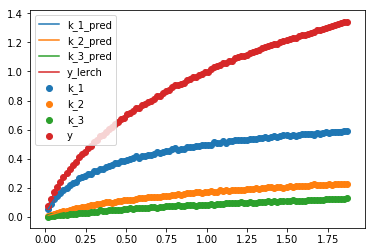

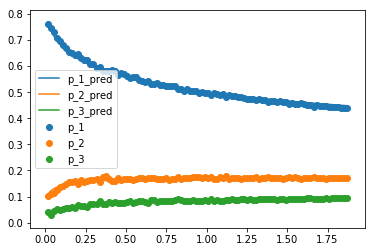

In [4]:
# table
df = corpus.TTR
df = df.iloc[:,:6]
df["x"] = df["m_tokens"] / model.M_z
df["y"] = df["n_types"] / model.N_z
display(df.head())

# new formula
polylogmodel = lambda x: x/(x-1)*polylog(1, (x-1)/x) # lambda x: lerchphi((x-1)/x, 1, 1)
lerchmodel_k = lambda x,n: (x/n - lerchphi((x-1)/x, 1, n))/(x-1)
lerchmodel_p = lambda x,n: (x/n - lerchphi((x-1)/x, 1, n))/(x * np.log(x))
df["y_lerch"] = df.x.apply(polylogmodel)
for n in range(1,4):
    df[f"k_{n}"] = df[f"lego_{n}"] / model.N_z
    df[f"p_{n}"] = df[f"lego_{n}"] / df["n_types"]
    df[f"k_{n}_pred"] = np.vectorize(lerchmodel_k)(df.x, n)
    df[f"p_{n}_pred"] = np.vectorize(lerchmodel_p)(df.x, n)


# plot
for n in range(1, 4):
    plt.scatter(df.x, df[f"k_{n}"])
    plt.plot(df.x, df[f"k_{n}_pred"])
plt.scatter(df.x, df.y)
plt.plot(df.x, df["y_lerch"])
plt.legend()
plt.show()

for n in range(1, 4):
    plt.scatter(df.x, df[f"p_{n}"])
    plt.plot(df.x, df[f"p_{n}_pred"])
plt.legend()
plt.show()

## Question 1: Can this new form be derived from eqn 11 ?

Prove:
$$
k_n(x) = \sum_{i=n}^\infty {i \choose n}\frac{x^n(1-x)^{i-n}}{n(n+1)} = \frac{ \frac{x}{n} - \phi\bigg(\frac{x-1}{x}, 1, n\bigg) }{x-1}
$$

## Question 2: Can we confirm eqn 14?

Prove:

$$
k_n(x) = (-1)^{n+1}\frac{x^n}{n!}y^{(n)}(x) \\
\frac{ \frac{x}{n} - \phi\bigg(\frac{x-1}{x}, 1, n\bigg) }{x-1} = (-1)^{n+1}\frac{x^n}{n!}\frac{d^n}{dx^n}\phi\bigg(\frac{x-1}{x}, 1, 1\bigg)
$$

## Question 3: What are the limits of $y, k_n, p_n$ as $x \to 1$ ?

Prove:

$$
\lim_{x \to 1} y(x) = \lim_{x \to 1} \phi\bigg(\frac{x-1}{x}, 1, 1\bigg) = \frac{x}{x-1} Li_1\bigg(\frac{x-1}{x}\bigg) = 1 \\
\lim_{x \to 1} k_n(x) = \lim_{x \to 1} \frac{ \frac{x}{n} - \phi\bigg(\frac{x-1}{x}, 1, n\bigg) }{x-1} = \frac{1}{n(n+1)} \\
\lim_{x \to 1} p_n(x) = \lim_{x \to 1} \frac{ \frac{x}{n} - \phi\bigg(\frac{x-1}{x}, 1, n\bigg) }{x\ln(x)} = \frac{1}{n(n+1)}
$$

## Question 4: What are the limits of $k_n, p_n:p_1$ as $x \to \infty$ ?

Prove:

$$
\lim_{x \to \infty} k_n(x) = \lim_{x \to \infty} \frac{ \frac{x}{n} - \phi\bigg(\frac{x-1}{x}, 1, n\bigg) }{x-1} = \frac{1}{n} \\
\lim_{x \to \infty} \frac{p_n(x)}{p_1(x)} = \lim_{x \to \infty} \frac{k_n(x)}{k_1(x)} = \frac{1}{n}
$$

## Question 5: Can we confirm $\{p_n(x)\}$ is a probability distribution for all $x$ ?

Prove:

$$
\sum_{n=1}^\infty p_n(x) = \sum_{n=1}^\infty \frac{ \frac{x}{n} - \phi\bigg(\frac{x-1}{x}, 1, n\bigg) }{x\ln(x)} = 1
$$

## Question 6: Can we also confirm $\{k_n(x)\}$ is a probability distribution for all $x$ ?

By definition:

$$
k_0(x) = 1 - y(x) = 1 - \phi\bigg(\frac{x-1}{x}, 1, 1\bigg)
$$

Prove:

$$
\sum_{n=0}^\infty k_n(x) = k_0(x) + \sum_{n=1}^\infty \frac{ \frac{x}{n} - \phi\bigg(\frac{x-1}{x}, 1, n\bigg) }{x - 1} = 1 \\
1 - \phi\bigg(\frac{x-1}{x}, 1, 1\bigg) + \sum_{n=1}^\infty \frac{ \frac{x}{n} - \phi\bigg(\frac{x-1}{x}, 1, n\bigg) }{x - 1} = 1 \\
\sum_{n=1}^\infty \frac{ \frac{x}{n} - \phi\bigg(\frac{x-1}{x}, 1, n\bigg) }{x - 1} = \phi\bigg(\frac{x-1}{x}, 1, 1\bigg) \\
\sum_{n=1}^\infty \frac{1}{n} - \frac{1}{x}\phi\bigg(\frac{x-1}{x}, 1, n\bigg) = \frac{x-1}{x}\phi\bigg(\frac{x-1}{x}, 1, 1\bigg) \\
\sum_{n=1}^\infty \frac{1}{n} - \frac{1}{x}\phi\bigg(\frac{x-1}{x}, 1, n\bigg) = Li_1\bigg(\frac{x-1}{x}\bigg) \\
\sum_{n=1}^\infty \frac{1}{n} - \frac{1}{x}\phi\bigg(\frac{x-1}{x}, 1, n\bigg) = \ln(x)
$$